# LBARTO: Long BART with O(n) attention

## Introduction
This notebook contains the code needed to:
1. convert BART to its long version by changing its full attention O(n^2) mechanism with a sliding window linear O(n) from Longformer or with LSG attention
2. finetune the resulting long model on the UniSum dataset (both standard and with additional special tokens versions) for better academic lectures summarization

In [1]:
#!pip install transformers datasets evaluate accelerate torch torchvision numpy nltk scikit-learn tensorboard wandb ray[tune] hyperopt ipynbname gdown matplotlib ipywidgets rouge_score bert_score lsg-converter

In [2]:
import os
import sys
from sys import stderr
import torch
from torch import nn, Tensor
from torch.cuda import OutOfMemoryError
import gc
import transformers
from transformers import (
    BartConfig,
    BartForConditionalGeneration,
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    LEDConfig,
    LEDForConditionalGeneration,
    LEDTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    SchedulerType,
    EarlyStoppingCallback,
    TrainerCallback,
    TrainerControl,
    TrainerState,
)
from transformers.models.bart.modeling_bart import shift_tokens_right
from transformers.models.led.modeling_led import LEDEncoderLayer, LEDDecoderLayer
from transformers.pytorch_utils import ALL_LAYERNORM_LAYERS
from transformers.trainer_pt_utils import get_parameter_names
import datasets
from datasets import DatasetDict, Dataset
import evaluate
from huggingface_hub import login as notebook_login
import gdown
from glob import glob
import subprocess
from subprocess import Popen, PIPE, CalledProcessError
import numpy as np
import json
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.search.hyperopt import HyperOptSearch
import ipynbname
import wandb
from wandb import AlertLevel
import random
from PIL import ImageDraw, ImageFont, Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import copy
from typing import List, Tuple, Dict, Optional
import re
from tqdm.auto import tqdm
from lsg_converter import LSGConverter, LSGBartForConditionalGeneration
import nltk
nltk.download("punkt")

COLAB = 'google.colab' in sys.modules  # True if on Google Colab
os.environ['COLAB'] = "true" if COLAB else ""
PLATFORM = "Colab" if COLAB else "local"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# whether to train one model or run a hyperparameter search with Ray Tune
search_hyperparams = False

# https://docs.wandb.ai/guides/integrations/huggingface
# set the wandb project name
try:
    current_notebook_name = ipynbname.name()
except:
    current_notebook_name = "LBARTO_summarization_finetuning"  # TODO: set manually
if search_hyperparams:
    current_notebook_name += "_HPO"
%env WANDB_PROJECT=$current_notebook_name
# save the best model as an artifact on wandb
%env WANDB_LOG_MODEL=true
# log everything
%env WANDB_WATCH=all

def get_gpu_mem_free_percent():
    mem_free, mem_total = torch.cuda.mem_get_info() if torch.cuda.is_available() else (0, 1)
    return mem_free / mem_total * 100

def print_gpu_mem_free_percent():
    print(f"GPU memory available {get_gpu_mem_free_percent():.2f}%")

def empty_gpu_mem():
    # try to avoid RuntimeError: CUDA out of memory.
    """try:
        del model
    except NameError:
        pass
    try:
        del trainer
    except NameError:
        pass"""
    torch.cuda.empty_cache()
    gc.collect()

print(f"Platform is {PLATFORM}")
print(f"Running in directory {os.getcwd()}")
print(f"PyTorch version {torch.__version__}")
print(f"Transformers version {transformers.__version__}")
print(f"Datasets version {datasets.__version__}")
print(f"GPU {'available' if torch.cuda.is_available() else 'unavailable'}")
print_gpu_mem_free_percent()
if get_gpu_mem_free_percent() < 80:
    print("Trying to free a bit of GPU memory...")
    empty_gpu_mem()
    print_gpu_mem_free_percent()

# export the current GPU name to the environment, may be used later (e.g. for the batch size)
# should be Tesla T4 (-> 16GB), Tesla K80 (-> 12GB), GeForce GTX 1060 (-> 6GB)
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader > /tmp/gpu_name
os.environ['GPU_NAME'] = open("/tmp/gpu_name", "r").read().strip()

!nvidia-smi
!df -h /

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')  # used to save model checkpoints
    from google.colab import output
    output.enable_custom_widget_manager()

env: WANDB_PROJECT=LBARTO_summarization_finetuning
env: WANDB_LOG_MODEL=true
env: WANDB_WATCH=all
Platform is local
Running in directory /home/caste/Documents/thesis/src/project/experiments/summarization
PyTorch version 1.13.0+cu117
Transformers version 4.25.1
Datasets version 2.7.1
GPU available
GPU memory available 89.11%


[nltk_data] Downloading package punkt to /home/caste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mon Feb 20 08:28:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2B:00.0  On |                  N/A |
| 30%   27C    P2    63W / 350W |   2641MiB / 24576MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Configure run

In [3]:
use_bart_large = False
use_domain_adaptation = "no"  # "long" (done on LSG/LED), "short" (done on BART), "no"
use_long_attention = True
use_lsg = True
use_extended_dataset = True
# see graphs: https://github.com/e-caste/thesis/tree/master/src/project/datasets/mitocw%2Byale_lectures_dataset
max_input_length = 16384 if use_long_attention else 1024
max_output_length = 384

In [4]:
if not os.path.isfile(os.path.expanduser("~/.huggingface/token")):
    notebook_login()

### 1. BART→LED / BART→LSG conversion

There are a few long Transformer approaches we can use to extend BART to accept input sequences of 16K tokens.  
From the [Longformer paper](https://arxiv.org/pdf/2004.05150.pdf):  
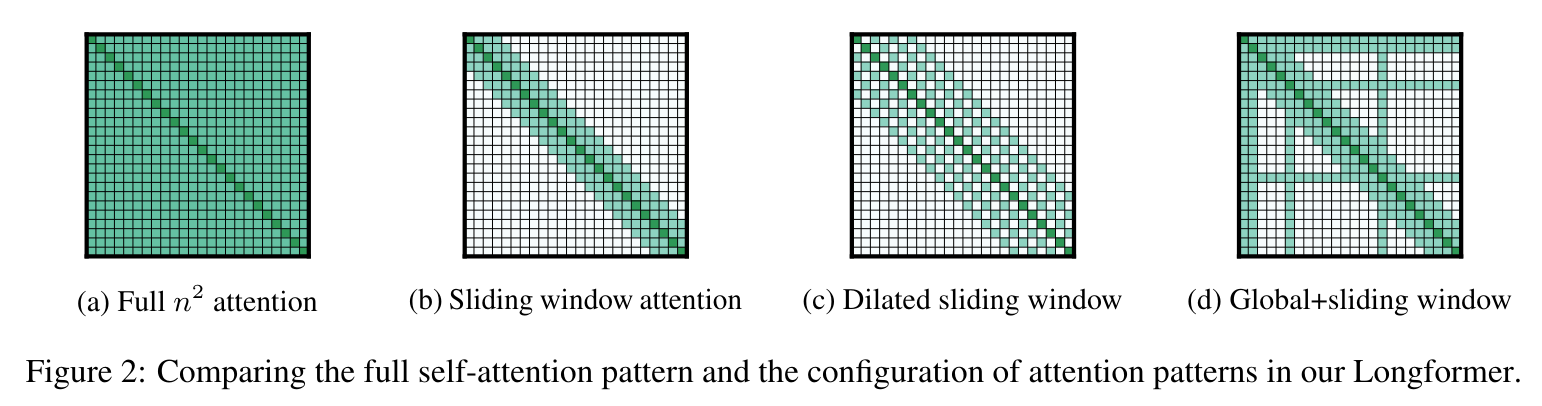  
From the [BigBird paper](https://papers.nips.cc/paper/2020/file/c8512d142a2d849725f31a9a7a361ab9-Paper.pdf):  
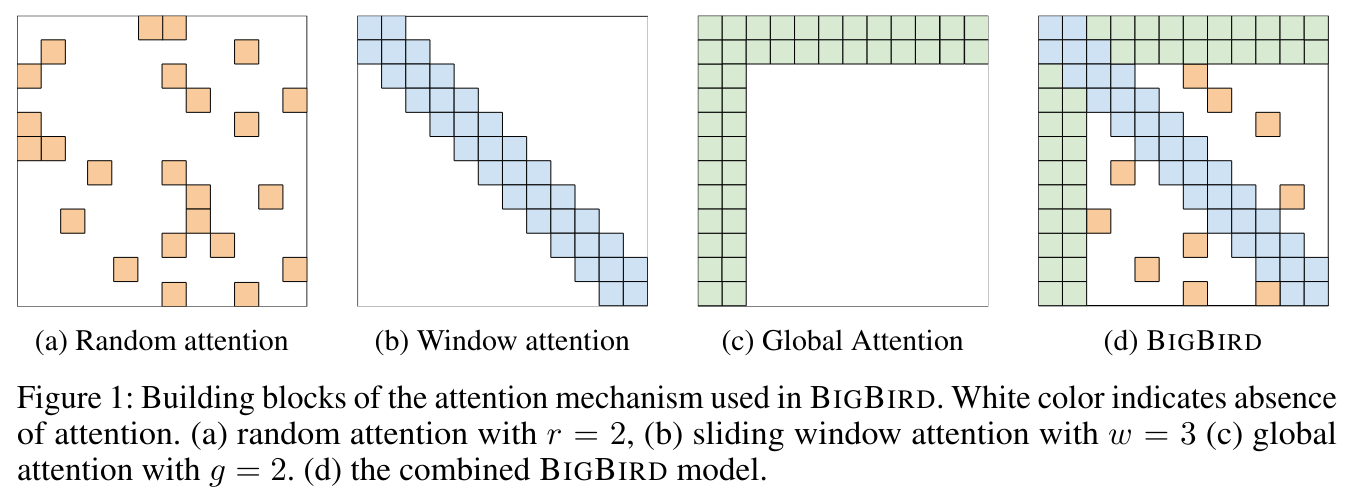  
From the [LSG (Local, Sparse, Global attention) paper](https://arxiv.org/pdf/2210.15497.pdf):  
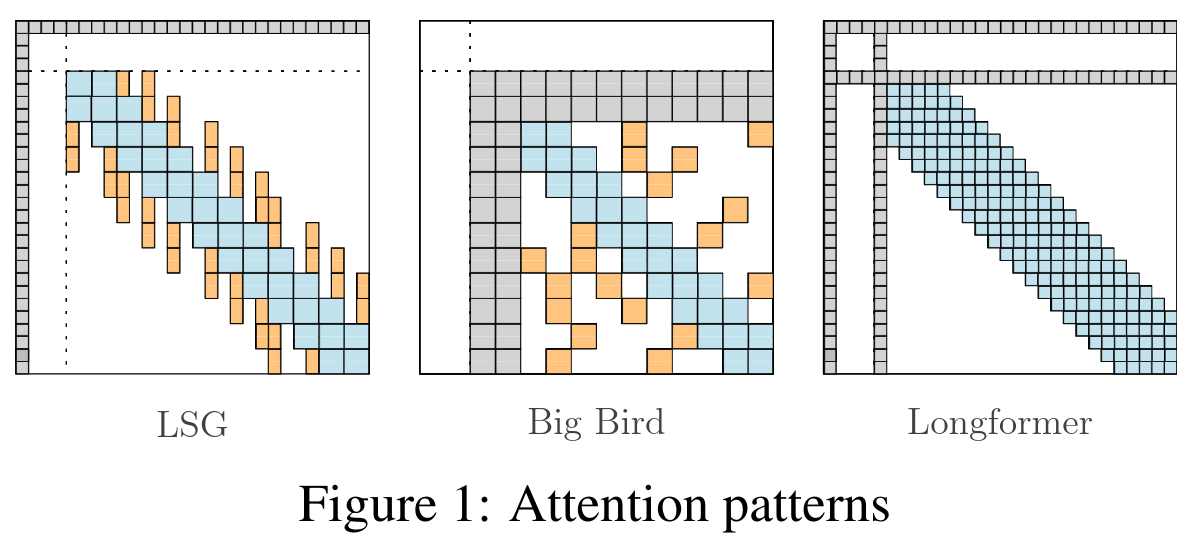
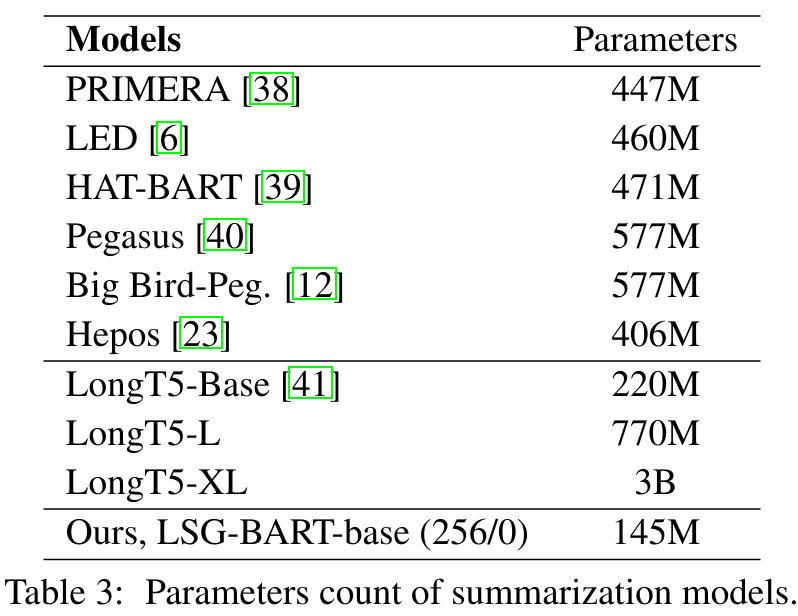

#### BART2LED
We base this work on the [script](https://github.com/allenai/longformer/blob/master/scripts/convert_bart_to_longformerencoderdecoder.py) provided by the Longformer paper authors, while taking a look at [this suggested re-implementation](https://gist.github.com/erichans/af745a381b28b1c019f96997ddac4cd7) and the [Transformers code for `LEDConfig`](https://github.com/huggingface/transformers/blob/main/src/transformers/models/led/configuration_led.py).

#### BART2LSG
The paper's authors provide a Python package (`lsg-converter`, repo [here](https://github.com/ccdv-ai/convert_checkpoint_to_lsg)) compatible with BART.

First, get the best BART model pretrained on the transcripts dataset.

In [5]:
model_id = f"BART{'-large' if use_bart_large else ''}" + (f"2{'LSG' if use_lsg else 'LED'}" if use_long_attention else "")
run_name = "_".join([PLATFORM, os.environ['GPU_NAME'], model_id, str(datetime.now())]).replace("\n", "").replace("/", "-").replace(":", "_").replace(" ", "-")

run = wandb.init(
    entity="e-caste",
    project=current_notebook_name,
    name=run_name,
    reinit=True,  # possibly needed for the wandb.init() call in trainer.train()
)
if use_domain_adaptation == "short":
    base_model = f"e-caste/BART_DLM_domain_adaptation/{'model-30s865ap:v0' if use_bart_large else 'model-2evbbo65:v0'}"
    artifact = run.use_artifact(base_model, type="model")
    artifact_dir = artifact.download()
elif use_domain_adaptation == "long":
    base_model = f"e-caste/LBARTO_DLM_domain_adaptation/{'model-ndpv5e3f:v0' if use_bart_large else 'model-32pop0vf:v0'}"
    artifact = run.use_artifact(base_model, type="model")
    artifact_dir = artifact.download()
else:
    base_model_name = f"facebook/bart-{'large' if use_bart_large else 'base'}"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: e-caste. Use `wandb login --relogin` to force relogin


#### BART2LED
Next, taking inspiration not from the [official script](https://github.com/allenai/longformer/blob/master/scripts/convert_bart_to_longformerencoderdecoder.py) by AllenAI to convert BART to LED by replacing its encoder's SelfAttention with LongformerSelfAttention, since it's obsolete, but from [this suggestion](https://gist.github.com/erichans/af745a381b28b1c019f96997ddac4cd7) which instantiates both BART and LED and then copies the weights from the former to the latter, we apply the conversion.

In [6]:
def copy_weights(bart, led):
    attentions_mapping = {'q_proj': 'query', 'k_proj': 'key', 'v_proj': 'value', 'out_proj': 'output'}

    led_parameters = dict(led.named_parameters())
    bart_parameters = dict(bart.named_parameters())

    parameters_missing_update = list(led_parameters.keys())
    print('Total parameters to copy:', parameters_missing_update)

    for bart_parameter in tqdm(bart_parameters):
        led_parameter = re.sub('^model.', 'led.', bart_parameter) #changing model preffix

        # copy position embeddings over and over to initialize the new position embeddings
        if re.search('model\..*.embed_positions.weight', bart_parameter):
            k = 0
            step = bart.model.encoder.embed_positions.weight.size(0) - 2
            while k < led_parameters[led_parameter].size(0) - 1:
                led_parameters[led_parameter].data[k:(k+step)].copy_(bart_parameters[bart_parameter].data[2:])
                k += step

            parameters_missing_update.remove(led_parameter)
            continue

        # replace the `modeling_bart.SelfAttention` object with `LEDSelfAttention`
        if re.search('model\.encoder.*self_attn\..*_proj', bart_parameter):
            fields = led_parameter.split('.')

            if 'out_proj' in bart_parameter:
                led_parameter = re.sub(fields[-2], attentions_mapping[fields[-2]], led_parameter)
                led_parameters[led_parameter].data.copy_(bart_parameters[bart_parameter].data)

                parameters_missing_update.remove(led_parameter)
            else:
                led_parameter_local = re.sub(fields[-2], f'longformer_self_attn.{attentions_mapping[fields[-2]]}', led_parameter)
                led_parameter_global = re.sub(fields[-2], f'longformer_self_attn.{attentions_mapping[fields[-2]]}_global', led_parameter)

                led_parameters[led_parameter_local].data.copy_(bart_parameters[bart_parameter].data)
                led_parameters[led_parameter_global].data.copy_(bart_parameters[bart_parameter].data)

                parameters_missing_update.remove(led_parameter_local)
                parameters_missing_update.remove(led_parameter_global)

            continue

        led_parameters[led_parameter].data.copy_(bart_parameters[bart_parameter].data)
        parameters_missing_update.remove(led_parameter)

    print('parameters missing update:', parameters_missing_update)
    assert len(parameters_missing_update) == 0


def create_long_model(
    save_model_to,
    base_model,
    tokenizer_name_or_path,
    max_pos
):
    bart = BartForConditionalGeneration.from_pretrained(base_model)
    model_type = f"allenai/led-{'large' if use_bart_large else 'base'}-16384"
    led = LEDForConditionalGeneration.from_pretrained(model_type)  # instantiate original LED and change weights and biases

    tokenizer = BartTokenizerFast.from_pretrained(tokenizer_name_or_path, model_max_length=max_pos)
    # ledTokenizer = LEDTokenizerFast.from_pretrained(tokenizer_name_or_path, model_max_length=max_pos)

    # in BART attention_probs_dropout_prob is attention_dropout, but LongformerSelfAttention
    # expects attention_probs_dropout_prob, so set it here
    led.config.attention_probs_dropout_prob = bart.config.attention_dropout

    # extend position embeddings
    tokenizer.model_max_length = max_pos
    tokenizer.init_kwargs['model_max_length'] = max_pos

    copy_weights(bart, led)

    led.save_pretrained(save_model_to)
    tokenizer.save_pretrained(save_model_to)

#### Convert and save the long model

In [7]:
if use_long_attention:
    # we don't need to convert the model to long since it already is
    if use_domain_adaptation == "long":
        tokenizer = BartTokenizerFast.from_pretrained(artifact_dir)
        model = (LSGBartForConditionalGeneration if use_lsg else LEDForConditionalGeneration).from_pretrained(artifact_dir)
    else:
        if use_lsg:
            # https://github.com/ccdv-ai/convert_checkpoint_to_lsg/blob/main/lsg_converter/converter.py
            # we use N global tokens with a stride of M in a way that each global token can attend
            # to all others if the input length is 16384 (<= N * M)
            converter = LSGConverter(
                max_sequence_length=max_input_length,
                random_global_init=False,
                global_positional_stride=64,
                keep_first_global_token=False,
                resize_lsg=False,
                use_token_ids=True,
                use_auth_token=False,
                seed=42,
            )
            model, tokenizer = converter.convert_from_pretrained(
                model_name_or_path=artifact_dir if use_domain_adaptation != "no" else base_model_name,
                architecture="BartForConditionalGeneration",
                use_auth_token=False,
                # next params are from: https://github.com/ccdv-ai/convert_checkpoint_to_lsg/blob/main/lsg_converter/bart/modeling_lsg_bart.py
                adaptive=True,
                base_model_prefix="lsg",
                block_size=128,
                lsh_num_pre_rounds=1,
                mask_first_token=False,
                num_global_tokens=512,  # this is the only non-default param, to "improve the flow of information inside the model"
                pass_global_tokens_to_decoder=True,
                pool_with_global=True,
                sparse_block_size=128,
                sparsity_factor=2,
                sparsity_type="norm",
            )
        else:
            save_model_to = "./BART2LED"
            create_long_model(
                save_model_to=save_model_to,
                base_model=artifact_dir if use_domain_adaptation != "no" else base_model_name,
                tokenizer_name_or_path=artifact_dir if use_domain_adaptation != "no" else base_model_name,
                max_pos=max_input_length,
            )
            tokenizer = BartTokenizerFast.from_pretrained(save_model_to)
            model = LEDForConditionalGeneration.from_pretrained(save_model_to)
else:
    tokenizer = BartTokenizerFast.from_pretrained(artifact_dir if use_domain_adaptation != "no" else base_model_name)
    model = BartForConditionalGeneration.from_pretrained(artifact_dir if use_domain_adaptation != "no" else base_model_name)

#model.to(DEVICE)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Some weights of LSGBartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.global_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test if the instantiated long model is working (code from [here](https://github.com/allenai/longformer/blob/caefee668e39cacdece7dd603a0bebf24df6d8ca/scripts/convert_bart_to_longformerencoderdecoder.py#L136)).

In [8]:
# with LED-large and LSG-large we get an out of memory error
if False:
    if not (use_bart_large and use_long_attention):
        TXT = "My friends are <mask> but they eat too many carbs."
        data = tokenizer([TXT], return_tensors='pt', padding='max_length', max_length=max_input_length)
        input_ids = data['input_ids'].to(DEVICE)
        attention_mask = data['attention_mask'].to(DEVICE)
        decoder_input_ids = shift_tokens_right(input_ids[:, :5], pad_token_id=tokenizer.pad_token_id, decoder_start_token_id=tokenizer.sep_token_id)
        logits = model(input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids, use_cache=False)[0]
        masked_index = (input_ids[0] == tokenizer.mask_token_id).nonzero().item()
        probs = logits[0, masked_index].softmax(dim=0)
        values, predictions = probs.topk(5)
        print(tokenizer.convert_ids_to_tokens(predictions))

In [9]:
#model

In [10]:
#model.config

### 2. LED/LSG finetuning on Yale+OCW dataset
For this we can follow the Transformer library authors' notebook: https://colab.research.google.com/drive/12LjJazBl7Gam0XBPy_y0CTOJZeZ34c2v?usp=sharing#scrollTo=W7-QHmRiAMB9

In [11]:
if use_extended_dataset:
    # must be same as in ../../datasets/mitocw+yale_lectures_dataset/3_dataset_extender.ipynb
    special_tokens = [
        "<w>",  # start sentence when the speaker was writing
        "</w>",  # end sentence when the speaker was writing
        "<nw>",  # start sentence when the speaker was not writing
        "</nw>",  # end sentence when the speaker was not writing
    ]

    tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
    model.resize_token_embeddings(len(tokenizer))

In [12]:
dataset_id = f"e-caste/mitocw_yale-lectures_summarization{'_extended' if use_extended_dataset else ''}"

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
raw_datasets = datasets.load_dataset(dataset_id, use_auth_token=True)
print(raw_datasets)


def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["target"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    if use_long_attention and not use_lsg:
        # create 0 global_attention_mask lists
        batch["global_attention_mask"] = len(batch["input_ids"]) * [
            [0 for _ in range(len(batch["input_ids"][0]))]
        ]
        # since above lists are references, the following line changes the 0 index for all samples
        batch["global_attention_mask"][0][0] = 1

    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch


tokenized_datasets = raw_datasets.map(
    process_data_to_model_inputs,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

for dataset in tokenized_datasets:
    tokenized_datasets[dataset].set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"] + ([] if use_lsg or not use_long_attention else ["global_attention_mask"]),
    )

print(tokenized_datasets)

Using custom data configuration e-caste--mitocw_yale-lectures_summarization_extended-8299397219cec323
Found cached dataset csv (/home/caste/.cache/huggingface/datasets/e-caste___csv/e-caste--mitocw_yale-lectures_summarization_extended-8299397219cec323/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'target'],
        num_rows: 1266
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'target'],
        num_rows: 159
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'target'],
        num_rows: 158
    })
})


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1266
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 159
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 158
    })
})


#### Load metrics

##### Load the customized script to compute the ROUGE metric so that we can store all evaluation results.

In [13]:
script_path = "./rouge.py"

if not os.path.isfile(script_path):
    !wget -O rouge.py https://raw.githubusercontent.com/huggingface/evaluate/d5ecbe472557e6ec3cf6173e6fe9b4fe67c4919e/metrics/rouge/rouge.py

    # use custom rouge module that also saves all the collected metrics to file
    with open(script_path, "r") as f:
        rouge_py = f.read()
    with open(script_path, "w") as f:
        f.write(
            rouge_py
                .replace(
                    "from rouge_score import rouge_scorer, scoring", 
                    "from rouge_score import rouge_scorer, scoring\nimport json"
                )
                .replace(
                    """def _compute(
            self, predictions, references, rouge_types=None, use_aggregator=True, use_stemmer=False, tokenizer=None
        ):
            if rouge_types is None:
                rouge_types = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

            multi_ref = isinstance(references[0], list)

            if tokenizer is not None:
                tokenizer = Tokenizer(tokenizer)

            scorer = rouge_scorer.RougeScorer(rouge_types=rouge_types, use_stemmer=use_stemmer, tokenizer=tokenizer)
            if use_aggregator:
                aggregator = scoring.BootstrapAggregator()
            else:
                scores = []

            for ref, pred in zip(references, predictions):
                if multi_ref:
                    score = scorer.score_multi(ref, pred)
                else:
                    score = scorer.score(ref, pred)
                if use_aggregator:
                    aggregator.add_scores(score)
                else:
                    scores.append(score)

            if use_aggregator:
                result = aggregator.aggregate()
                for key in result:
                    result[key] = result[key].mid.fmeasure

            else:
                result = {}
                for key in scores[0]:
                    result[key] = list(score[key].fmeasure for score in scores)

            return result""",

            # replacement that saves all scores to scores_file_path
            """def _compute(
            self, predictions, references, rouge_types=None, use_aggregator=True, use_stemmer=False, tokenizer=None, scores_file_path="./rouge_scores.json"
        ):
            if rouge_types is None:
                rouge_types = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

            multi_ref = isinstance(references[0], list)

            if tokenizer is not None:
                tokenizer = Tokenizer(tokenizer)

            scorer = rouge_scorer.RougeScorer(rouge_types=rouge_types, use_stemmer=use_stemmer, tokenizer=tokenizer)
            aggregator = scoring.BootstrapAggregator()
            scores = []

            for ref, pred in zip(references, predictions):
                if multi_ref:
                    score = scorer.score_multi(ref, pred)
                else:
                    score = scorer.score(ref, pred)
                aggregator.add_scores(score)
                scores.append(score)

            result = aggregator.aggregate()
            for key in result:
                result[key] = result[key].mid.fmeasure

            _result = {}
            for key in scores[0]:
                _result[key] = list(score[key].fmeasure for score in scores)
            with open(scores_file_path, "w") as f:
                json.dump(_result, f)

            return result""")
        )

    # !cat rouge.py

In [14]:
try:
    scores_file_path = f"./{'drive/MyDrive/' if COLAB else ''}rouge_scores_model-{model_id.split('/')[-1]}_dataset-{dataset_id.split('/')[-1]}_{str(datetime.now()).replace(':', '_').replace(' ', '-')}.json"
except NameError:
    # this happens if we want to test a previous model
    scores_file_path = "/dev/null"
rouge = evaluate.load(script_path)  # load customized metric
# https://huggingface.co/spaces/evaluate-metric/bertscore
bertscore = evaluate.load("bertscore")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels[labels == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence -- but it also works with a list of strings
    #decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    #decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=False,  # no Porter stemmer
        scores_file_path=scores_file_path,
    )

    bertscore_result = bertscore.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        lang="en",
        # see here for best models: https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI
        # TODO: should we use the default roberta-large or even facebook/bart-base so the tokenizer vocabulary is the same? no
        model_type="microsoft/deberta-xlarge-mnli",  # NOTE: this takes ~5GB of memory at the end of the first evaluation
        idf=False,
        rescale_with_baseline=False,
        use_fast_tokenizer=True,
        batch_size=1,
        nthreads=1,
        verbose=False,
        device="cpu" if use_long_attention and use_lsg else "cuda",  # avoid CUDA OutOfMemoryError
    )

    result = {}
    for k, v in rouge_result.items():
        result[k] = v
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result['gen_len'] = np.mean(prediction_lens)
    for k, v in bertscore_result.items():
        if k != "hashcode":
            result[f'bertscore_{k}'] = np.mean(v)

    return result

#### Set up training parameters

##### Model configuration

In [15]:
# model config
model.config.use_cache = False
# model.config.gradient_checkpointing = True

# set generate hyperparameters
# https://huggingface.co/docs/transformers/main/en/main_classes/configuration#transformers.PretrainedConfig
model.config.max_length = max_output_length  # Maximum length that will be used by default in the generate method of the model.
model.config.min_length = 32  # 32 from Yale+MITOCW stats. Minimum length that will be used by default in the generate method of the model.
model.config.length_penalty = 2.0  # Exponential penalty to the length that is used with beam-based generation. It is applied as an exponent to the sequence length, which in turn is used to divide the score of the sequence. Since the score is the log likelihood of the sequence (i.e. negative), length_penalty > 0.0 promotes longer sequences, while length_penalty < 0.0 encourages shorter sequences.
model.config.no_repeat_ngram_size = 3  # Value that will be used by default in the — generate method of the model for no_repeat_ngram_size. If set to int > 0, all ngrams of that size can only occur once.
# make evaluation faster - LED 2h -> 30min
model.config.num_beams = 5  # Number of beams for beam search that will be used by default in the generate method of the model. 1 means no beam search.
model.config.early_stopping = True  # Flag that will be used by default in the generate method of the model. Whether to stop the beam search when at least num_beams sentences are finished per batch or not.

model.config

LSGBartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "adaptive": true,
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": "LSGBartForConditionalGeneration",
  "attention_dropout": 0.1,
  "auto_map": {
    "AutoModel": "modeling_lsg_bart.LSGBartModel",
    "AutoModelForCausalLM": "modeling_lsg_bart.LSGBartForCausalLM",
    "AutoModelForQuestionAnswering": "modeling_lsg_bart.LSGBartForQuestionAnswering",
    "AutoModelForSeq2SeqLM": "modeling_lsg_bart.LSGBartForConditionalGeneration",
    "AutoModelForSequenceClassification": "modeling_lsg_bart.LSGBartForSequenceClassification"
  },
  "base_model_prefix": "lsg",
  "block_size": 128,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_s

In [16]:
tensorboard_logging_dir = None  # f"./tensorboard/{run_name}"
epochs = 10
lr = 5e-5 if use_bart_large else 7.5e-5
weight_decay = 0.01
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-8
eval_delay = 0
batch_size_train = 1 if use_bart_large else 2  # with 24 GB
batch_size_eval = 1 if use_bart_large else 2
gradient_accumulation_steps = 32 if use_bart_large else 16
evaluations_per_epoch = 1
early_stopping_patience = epochs * evaluations_per_epoch  # // 2  # evaluations
total_steps = len(tokenized_datasets['train']) * epochs / (batch_size_train * gradient_accumulation_steps)
warmup_steps = total_steps // 10  # (total_steps // 5) if use_bart_large else (total_steps // 10)
eval_and_save_steps = int(total_steps / (evaluations_per_epoch * epochs))
use_custom_scheduler = False

if use_custom_scheduler:
    # https://github.com/huggingface/transformers/blob/5fa0b17c3d10cdb6411a173a7dce42b0de56a8f2/src/transformers/trainer.py#L1019
    decay_parameters = get_parameter_names(model, ALL_LAYERNORM_LAYERS)
    decay_parameters = [name for name in decay_parameters if "bias" not in name]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters],
            "weight_decay": weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
            "weight_decay": 0.0,
        },
    ]

    optimizer = torch.optim.AdamW(
        params=optimizer_grouped_parameters,
        lr=lr,
        betas=(adam_beta1, adam_beta2),
        eps=adam_epsilon,
        #weight_decay=weight_decay,
        amsgrad=True,  # https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
    )

    scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
        num_cycles=epochs,
        last_epoch=-1,
    )

training_args = Seq2SeqTrainingArguments(
    output_dir=current_notebook_name,
    run_name=run_name,
    save_strategy="steps",
    save_steps=eval_and_save_steps,
    save_total_limit=evaluations_per_epoch * epochs,
    evaluation_strategy="steps",
    eval_steps=eval_and_save_steps,
    eval_delay=eval_delay,
    auto_find_batch_size=False,
    per_device_train_batch_size=batch_size_train,
    per_device_eval_batch_size=batch_size_eval,
    num_train_epochs=epochs,
    adam_beta1=adam_beta1,
    adam_beta2=adam_beta2,
    adam_epsilon=adam_epsilon,
    learning_rate=lr,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    lr_scheduler_type=SchedulerType.LINEAR,
    # make the model fit in the GPU
    gradient_checkpointing=True,
    gradient_accumulation_steps=gradient_accumulation_steps,
    # fp16 vs bf16: https://www.reddit.com/r/MachineLearning/comments/vndtn8/comment/ie6dr2u/?utm_source=share&utm_medium=web2x&context=3
    # for full precision use tf32=True: https://developer.nvidia.com/blog/accelerating-ai-training-with-tf32-tensor-cores/
    fp16=True,  # LED needs fp16: https://discuss.huggingface.co/t/model-pre-training-precision-database-fp16-fp32-bf16/5671
    fp16_opt_level="O1",
    bf16=False,  # needs RTX 3090
    fp16_full_eval=False,
    bf16_full_eval=False,  # Whether to use full bfloat16 evaluation instead of 32-bit. This will be faster and save memory but can harm metric values.
    half_precision_backend="cuda_amp",  # apex is deprecated: https://discuss.pytorch.org/t/torch-cuda-amp-vs-nvidia-apex/74994/2
    predict_with_generate=True,
    generation_max_length=max_output_length,
    generation_num_beams=model.config.num_beams,
    load_best_model_at_end=True,
    metric_for_best_model="rouge2",  # Must be the name of a metric returned by the evaluation with or without the prefix "eval_". Will default to "loss" if unspecified
    logging_dir=tensorboard_logging_dir,
    logging_strategy="steps",
    logging_steps=1,  # crucial for logging training loss -- Number of update steps between two logs if `logging_strategy="steps"`
    remove_unused_columns=True,
    report_to="wandb",
    disable_tqdm=search_hyperparams,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
    optimizers=(optimizer, scheduler) if use_custom_scheduler else (None, None),
    # model_init=model_init if search_hyperparams else None,
)

run_name

Using cuda_amp half precision backend


'local_NVIDIA-GeForce-RTX-3090_BART2LSG_2023-02-20-08_28_47.187204'

#### Train the model

In [18]:
# we can run a grid search for the best hyperparameter combination
# https://huggingface.co/blog/ray-tune
if search_hyperparams:
    # Default objective is the sum of all metrics
    # when metrics are provided, so we have to maximize it.
    # this doesn't save a model artifact to wandb
    trainer.hyperparameter_search(
        direction="maximize",
        backend="ray",
        n_trials=3,  # number of trials
        # search_alg=HyperOptSearch(metric="objective", mode="max"),
        scheduler=PopulationBasedTraining(metric="objective", mode="max"),
    )
else:
    try:
        # this saves the best model as an artifact on wandb
        train_result = trainer.train(resume_from_checkpoint=None)
    except OutOfMemoryError as oome:
        print("Out of memory error: trying to free PyTorch cache...", file=stderr)
        empty_gpu_mem()
        wandb.alert(
            title=f"Run out of memory for {current_notebook_name}",
            text=f"Run name: {run_name}.\nSee details at https://wandb.ai/e-caste/{current_notebook_name}",
            level=AlertLevel.ERROR,
        )
        wandb.finish()
        raise oome
    except KeyboardInterrupt:
        wandb.alert(
            title=f"Run interrupted for {current_notebook_name}",
            text=f"Run name: {run_name}.\nManually interrupted.\nSee details at https://wandb.ai/e-caste/{current_notebook_name}",
            level=AlertLevel.WARN,
        )
        wandb.finish()
    except Exception as e:
        wandb.alert(
            title=f"Run errored out for {current_notebook_name}",
            text=f"Run name: {run_name}.\nException: {e}.\nSee details at https://wandb.ai/e-caste/{current_notebook_name}",
            level=AlertLevel.ERROR,
        )
        wandb.finish()
        raise e

/home/caste/Documents/thesis/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1266
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 390
  Number of trainable parameters = 163409664
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len,Bertscore Precision,Bertscore Recall,Bertscore F1
39,3.365100,3.005969,0.319175,0.093120,0.210257,0.210559,97.911392,0.609143,0.602367,0.604317
78,3.057400,2.911722,0.316062,0.091300,0.215562,0.216124,70.348101,0.633481,0.603838,0.616839
117,2.872700,2.859568,0.333859,0.102322,0.216466,0.216511,82.303797,0.625869,0.613304,0.618173
156,2.561300,2.846770,0.325050,0.098270,0.215883,0.216471,67.968354,0.642841,0.608535,0.623725
195,2.550400,2.858387,0.321049,0.099857,0.216477,0.216867,65.272152,0.647210,0.612180,0.627799
234,2.289300,2.866442,0.335414,0.106086,0.225100,0.225464,73.506329,0.642442,0.617921,0.628642
273,2.136600,2.883295,0.332221,0.103701,0.216950,0.217072,86.316456,0.628482,0.618364,0.622004
312,2.040100,2.901966,0.334850,0.105159,0.218535,0.218985,82.601266,0.636480,0.621720,0.627733
351,2.060700,2.897032,0.338399,0.108732,0.225792,0.226281,83.822785,0.634770,0.622107,0.627139
390,2.045300,2.912776,0.337256,0.107408,0.221224,0.221547,82.139241,0.636661,0.621563,0.627811


***** Running Evaluation *****
  Num examples = 158
  Batch size = 2
loading configuration file config.json from cache at /home/caste/.cache/huggingface/hub/models--microsoft--deberta-xlarge-mnli/snapshots/5b07a9086c1dbb79981ff7b05b4d1ad83b3af51c/config.json
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-xlarge-mnli",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "CONTRADICTION",
    "1": "NEUTRAL",
    "2": "ENTAILMENT"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "CONTRADICTION": 0,
    "ENTAILMENT": 2,
    "NEUTRAL": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 48,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu"

In [19]:
trainer.save_model()  # Saves the tokenizer too for easy upload

metrics = train_result.metrics
metrics["train_samples"] = len(tokenized_datasets['train'])
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

Saving model checkpoint to LBARTO_summarization_finetuning
Configuration saved in LBARTO_summarization_finetuning/config.json
Model weights saved in LBARTO_summarization_finetuning/pytorch_model.bin
tokenizer config file saved in LBARTO_summarization_finetuning/tokenizer_config.json
Special tokens file saved in LBARTO_summarization_finetuning/special_tokens_map.json


***** train metrics *****
  epoch                    =        9.99
  total_flos               = 114862446GF
  train_loss               =      2.5996
  train_runtime            =  8:32:18.54
  train_samples            =        1266
  train_samples_per_second =       0.412
  train_steps_per_second   =       0.013


#### Evaluate the model on the test dataset and save all predictions
First, save them locally to a JSON file.  
Then, upload the JSON file to the Weights & Biases run so it's preserved.

In [20]:
def compute_test_predictions(
    run_name: str,
    save_predictions_locally: bool = True,
    upload_saved_predictions_to_wandb: bool = True,
) -> str:
    results = trainer.predict(tokenized_datasets['test'])  # .select(range(8))
    print("Scores computed by rouge_score's BootstrapAggregator:")
    scores = "\n".join(f"{k}: {v}" for k, v in results.metrics.items())
    metrics = results.metrics
    metrics["test_samples"] = len(tokenized_datasets['test'])
    trainer.log_metrics("test", metrics)
    trainer.save_metrics("test", metrics)

    if save_predictions_locally:
        predictions = [
            {'predicted': predicted, 'original': original['target']}
            for predicted, original in zip(
               tokenizer.batch_decode(results.predictions, skip_special_tokens=True),
               raw_datasets['test'],
            )
        ]

        predictions_file_name = f"{current_notebook_name}/predictions_{run_name}.json"
        with open(predictions_file_name, "w") as f:
            json.dump(predictions, f)

        if upload_saved_predictions_to_wandb:
            wandb.save(predictions_file_name, base_path=current_notebook_name, policy="now")

    return scores

In [21]:
scores = compute_test_predictions(run_name=run_name)

# print scores computed from file
print("📏" * 15)
print(f"Scores computed by averaging the scores saved in {scores_file_path}:")
with open(scores_file_path, "r") as f:
    metrics = json.load(f)
for key in metrics:
    print(f"{key}: {sum(metrics[key]) / len(metrics[key])}")

# print the top-3 and top5- of all the metrics
print("📏" * 15)
for key in metrics:
    top_3 = sorted(metrics[key], reverse=True)[:3]
    top_5 = sorted(metrics[key], reverse=True)[:5]
    print(f"{key}: top-3 {top_3} - top-3 mean {sum(top_3) / len(top_3)} | top-5 {top_5} - top-5 mean {sum(top_5) / len(top_5)}")

***** Running Prediction *****
  Num examples = 159
  Batch size = 2


Scores computed by rouge_score's BootstrapAggregator:
***** test metrics *****
  test_bertscore_f1        =     0.6313
  test_bertscore_precision =     0.6406
  test_bertscore_recall    =     0.6242
  test_gen_len             =    81.6981
  test_loss                =     2.8591
  test_rouge1              =     0.3469
  test_rouge2              =     0.1105
  test_rougeL              =     0.2257
  test_rougeLsum           =     0.2261
  test_runtime             = 0:36:57.84
  test_samples             =        159
  test_samples_per_second  =      0.072
  test_steps_per_second    =      0.036
📏📏📏📏📏📏📏📏📏📏📏📏📏📏📏
Scores computed by averaging the scores saved in ./rouge_scores_model-BART2LSG_dataset-mitocw_yale-lectures_summarization_extended_2023-02-20-08_29_03.455264.json:
rouge1: 0.34734769686056566
rouge2: 0.11037484584462867
rougeL: 0.2256969417507275
rougeLsum: 0.2256969417507275
📏📏📏📏📏📏📏📏📏📏📏📏📏📏📏
rouge1: top-3 [0.6, 0.5686274509803922, 0.5660377358490566] - top-3 mean 0.5782217289431496 

#### Randomly show one summarization example

In [22]:
index = np.random.randint(0, len(tokenized_datasets['test']))
results = trainer.predict(
    test_dataset=tokenized_datasets['test'].select([index]),
    max_length=model.config.max_length,
    num_beams=5,
)
print(f"Original summary:\n{raw_datasets['test'][index]['target']}")
print("-" * 30)
print(f"Predicted summary:\n{tokenizer.batch_decode(results.predictions, skip_special_tokens=True)[0]}")
print("-" * 30)
print(f"Original transcript:\n{raw_datasets['test'][index]['text']}")

***** Running Prediction *****
  Num examples = 1
  Batch size = 2


Original summary:
Herb Gross illustrates how the Jacobian arises when changing coordinates in order to calculate a double integral.
------------------------------
Predicted summary:
In this lecture, Professor Gendler discusses double integrals in terms of polar coordinates. The Jacobian matrix and the Jacobian determinant are discussed in greater detail, along with their applications in the study of multiple integrals.
------------------------------
Original transcript:
<w>PROFESSOR: Hi.</w><w>In the reading assignment for today, you'll notice in the textbook that the topic is double integrals in terms of polar coordinates.</w><w>Now, the trouble with polar coordinates is that, aside from straight lines, they're perhaps the only coordinate system that we've studied in terms of Euclidean geometry in a high school class.</w><w>And consequently, if we were to have a change of variables other than strict linear changes of variables or polar coordinates, it might be difficult to geometrical

In [23]:
wandb.alert(
    title=f"Run finished for {current_notebook_name}",
    text=f"Run name: {run_name}.\n\n{scores}\nSee details at https://wandb.ai/e-caste/{current_notebook_name}",
    level=AlertLevel.INFO,
)
wandb.finish()
empty_gpu_mem()

eval/bertscore_f1,▁▅▅▇██▆███
eval/bertscore_precision,▁▅▄▇█▇▅▆▆▆
eval/bertscore_recall,▁▂▅▃▄▇▇███
eval/gen_len,█▂▅▂▁▃▆▅▅▅
eval/loss,█▄▂▁▂▂▃▃▃▄
eval/rouge1,▂▁▇▄▃▇▆▇██
eval/rouge2,▂▁▅▄▄▇▆▇█▇
eval/rougeL,▁▃▄▄▄█▄▅█▆
eval/rougeLsum,▁▃▄▄▄█▄▅█▆
eval/runtime,█▂▄▂▁▃▆▅▅▅
eval/samples_per_second,▁▆▄▇█▆▂▃▃▃


## Results
Note: all [TRAIN], [EVAL] and [TEST] metrics are computed with the model at the best epoch.

| Run  |  Base Model | Dataset | Domain Adaptation | Long Attention Type  | Precision | Learning Rate |Epochs |Best Epoch |Effective Batch Size (Gradient Accumulation Steps * Batch Size) |Metric for Best Model |Warmup Steps | Num Beams | Length Penalty | [TRAIN] Loss |[EVAL] Loss | [TEST] Loss |[EVAL] Generation Length | [TEST] Generation Length | [EVAL] BERT-score F1 | [TEST] BERT-score F1 | [EVAL] ROUGE1 | [TEST] ROUGE1 | [EVAL] ROUGE2 | [TEST] ROUGE2 | [EVAL] ROUGEL | [TEST] ROUGEL |
|----------|---------|---------|---------|---------|---------|--------------------|----------|----------|----------------|---------------------------|-----------------------------|--------------------|-----------------|------------------|-----------------------------------|--------------------------------|------------------------------------|-----------------------------|------------------------------|----------------------|----------------------|---------------------|----------------------|----------------------|---------------------|--|
| 2023-01-17-12_16_53.300551 | BART-base | standard | short | LSG | fp16 | 1e-4 | 10 | 9 | 8\*2 | ROUGE2 | 10% | 5 | 2.0 |1.134 | 3.161 | 3.139 | 85.25 | 82.65 | 0.631 | 0.633 | 0.342 | 0.355 | 0.106 | 0.109 | 0.222 | 0.227 |
| 2023-01-17-22_33_56.702951 | BART-base | standard | short | LSG | fp16 | 1e-4 | 10 | 10 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 1.670 | 3.037 | 3.014 | 80.84 | 77.66 | 0.629 | 0.630 | 0.339 | 0.343 | 0.107 | 0.109 | 0.226 | 0.223 |
| 2023-01-18-10_43_30.535439 | BART-base | standard | short | LED | fp16 | 1e-4 | 10 | 9 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 1.269 | 3.167 | 3.139 | 83.69 | 81.13 | 0.626 | 0.633 | 0.343 | 0.349 | 0.109 | 0.112 | 0.226 | 0.229 |
| 2023-01-18-20_57_57.898940 | BART-base | extended | short | LED | fp16 | 1e-4 | 10 | 10 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 1.278 | 3.180 | 3.166 | 81.48 | 79.16 | 0.628 | 0.631 | 0.339 | 0.347 | 0.103 | 0.111 | 0.220 | 0.226 |
| 2023-01-19-08_53_05.686211 | BART-base | extended | short | LSG | fp16 | 1e-4 | 10 | 8 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 1.715 | 2.988 | 2.957 | 83.48 | 81.40 | 0.624 | 0.633 | 0.332 | 0.344 | 0.105 | 0.110 | 0.221 | 0.226 |
| 2023-01-20-09_58_30.142425 | BART-large | extended | short | LSG | fp16 | 1e-4 | 10 | 8 | 32\*1 | ROUGE2 | 10% | 5 | 2.0 | 0.829 | 3.054 | 3.068 | 75.44 | 81.39 | 0.633 | 0.644 | 0.334 | 0.352 | 0.110 | 0.118 | 0.223 | 0.233 |
| 2023-01-21-10_49_18.884291 | BART-large | extended | short | LSG | fp16 | 5e-5 | 10 | 10 | 32\*1 | ROUGE2 | 20% | 5 | 2.0 | 1.356 | 2.745 | 2.756 | 84.62 | 88.77 | 0.636 | 0.644 | 0.341 | 0.358 | 0.110 | 0.116 | 0.222 | 0.228 |
| 2023-01-22-12_32_01.524479 | BART-large | extended | short | LSG | fp16 | 2.5e-5 | 10 | 9 | 32\*1 | ROUGE2 | 20% | 3 | 2.0 | 1.872 | 2.511 | 2.516 | 77.63 | 73.96 | 0.634 | 0.637 | 0.328 | 0.343 | 0.103 | 0.107 | 0.223 | 0.225 |
| 2023-01-25-09_48_27.963496 | BART-base | standard | short | LSG | fp16 | 5e-5 | 10 | 8 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 2.193100 | 2.875411 | 2.837965 | 77.031646 | 72.666667 | 0.622813 | 0.624729 | 0.327982 | 0.328411 | 0.097914 | 0.102670 | 0.215097 | 0.219396 |
| 2023-01-25-18_12_31.697222 | BART-base | standard | short | LSG | fp16 | 7.5e-5 | 10 | 8 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 1.901900 | 2.922150 | 2.888389 | 79.348101 | 77.383648 | 0.625008 | 0.626502 | 0.334832 | 0.335341 | 0.103901 | 0.106051 | 0.222260 | 0.217917 |
| 2023-01-26-08_57_47.532395 | BART-base | extended | short | LSG | fp16 | 7.5e-5 | 10 | 9 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 1.974200 | 2.942458 | 2.906276 | 79.955696 | 76.559748 | 0.624148 | 0.629659 | 0.327457 | 0.337132 | 0.101134 | 0.101583 | 0.213845 | 0.215661 |
| 2023-01-26-17_45_32.755723 | BART-large | extended | short | LSG | fp16 | 7.5e-5 | 10 | 9 | 32\*1 | ROUGE2 | 10% | 5 | 2.0 | 1.048200 | 2.892942 | 2.902681 | 90.905063 | 92.503145 | 0.631724 | 0.641338 | 0.345147 | 0.361550 | 0.107417 | 0.112890 | 0.222964 | 0.230276 |
| 2023-01-27-16_01_14.842299 | BART-base | standard | short | LED | fp16 | 7.5e-5 | 10 | 7 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 1.678400 | 2.983276 | 2.946079 | 83.943038 | 80.748428 | 0.624587 | 0.628991 | 0.333389 | 0.349580 | 0.103055 | 0.115061 | 0.220568 | 0.227061 |
| 2023-01-28-12_46_39.213045 | BART-base | standard | short | none | fp16 | 7.5e-5 | 10 | 7 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 2.388000 | 3.264798 | 3.259853 | 78.196203 | 77.886792 | 0.612711 | 0.609197 | 0.315394 | 0.316064 | 0.092319 | 0.092985 | 0.210087 | 0.213553 |
| 2023-01-28-13_46_04.027268 | BART-large | standard | short | none | fp16 | 5e-5 | 10 | 7 | 32\*1 | ROUGE2 | 10% | 5 | 2.0 | 1.859600 | 3.043905 | 3.042891 | 102.981013 | 96.836478 | 0.613986 | 0.619152 | 0.319605 | 0.321216 | 0.094985 | 0.099213 | 0.207986 | 0.216530 |
| 2023-02-15-12_14_12.384989 | BART-large | standard | short | LED | fp16 | 5e-5 | 10 | 6 | 32\*1 | ROUGE2 | 10% | 5 | 2.0 | 1.144900 | 2.859027 | 2.8143 | 62.215190 | 63.239 | 0.634467 | 0.6431 | 0.322980 | 0.3447 | 0.105310 | 0.1144 | 0.223852 | 0.2329 |
| 2023-02-01-09_29_07.420995 | BART-large | standard | short | LSG | fp16 | 5e-5 | 10 | 8 | 32\*1 | ROUGE2 | 10% | 5 | 2.0 | 1.325000 | 2.681611 | 2.659523 | 79.227848 | 79.427673 | 0.634764 | 0.638364 | 0.341972 | 0.345735 | 0.107466 | 0.116250 | 0.225186 | 0.226025 |
| 2023-02-02-09_31_26.550812 | BART-large | extended | short | LSG | fp16 | 5e-5 | 10 | 8 | 32\*1 | ROUGE2 | 10% | 5 | 2.0 | 1.355100 | 2.676895 | 2.683649 | 82.759494 | 86.798742 | 0.636054 | 0.637780 | 0.344564 | 0.348730 | 0.114631 | 0.111176 | 0.228333 | 0.225194 |
| 2023-02-16-15_21_21.167658 | BART-base | standard | no | LSG | fp16 | 7.5e-5 | 10 | 9 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 2.026200 | 2.898775 | 2.8548 | 88.702532 | 85.4465 | 0.630994 | 0.6303 | 0.347807 | 0.3507 | 0.110479 | 0.1114 | 0.227488 | 0.2276 |
| 2023-02-17-09_37_45.270224 | BART-large | standard | no | LSG | fp16 | 5e-5 | 10 | 9 | 32\*1 | ROUGE2 | 10% | 5 | 2.0 | 1.386100 | 2.650294 | 2.6531 | 78.575949 | 80.4151 | 0.636914 | 0.6422 | 0.340522 | 0.3484 | 0.111061 | 0.1138 | 0.228197 | 0.231|
| 2023-02-19-09_51_27.022972 | BART-base | standard | long | LSG | fp16 | 7.5e-5 | 10 | 7 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 2.031800 | 2.862385 | 2.8105 | 76.430380 | 77.044 | 0.626987 | 0.6284 | 0.329779 | 0.3371 | 0.100925 | 0.1081 | 0.216742 | 0.2203|
| 2023-02-20-08_28_47.187204 | BART-base | extended | no | LSG | fp16 | 7.5e-5 | 10 | 9 | 16\*2 | ROUGE2 | 10% | 5 | 2.0 | 2.060700 | 2.897032 | 2.8591 | 83.822785 | 81.6981 | 0.627139 | 0.6313 | 0.338399 | 0.3469 | 0.108732 | 0.1105 | 0.225792 | 0.2257|